# Celebrity Image Classification

## GPU

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Import librairies

In [ ]:
from google.colab import drive 
import matplotlib.pyplot as plt
import pandas as pd
import io
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
drive.mount('/content/gdrive')
from google.colab.patches import cv2_imshow

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import keras
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50

from keras import layers
from keras.models import Model
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from skimage.feature import hog
from skimage import data, exposure


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data 

In [ ]:
fichiers = [f for f in listdir('gdrive/My Drive/dataset_celebrity_class') if isfile(join('gdrive/My Drive/dataset_celebrity_class', f))]
fichiers.sort()
print(fichiers)

['00000000.jpg', '00000001.jpg', '00000002.jpg', '00000003.jpg', '00000004.jpg', '00000005.jpg', '00000006.jpg', '00000007.jpg', '00000008.jpg', '00000009.jpg', '00000010.jpg', '00000011.jpg', '00000012.jpg', '00000013.jpg', '00000014.jpg', '00000015.jpg', '00000016.jpg', '00000017.jpg', '00000018.jpg', '00000019.jpg', '00000020.jpg', '00000021.jpg', '00000022.jpg', '00000023.jpg', '00000024.jpg', '00000025.jpg', '00000026.jpg', '00000027.jpg', '00000028.jpg', '00000029.jpg', '00000030.jpg', '00000031.jpg', '00000032.jpg', '00000033.jpg', '00000034.jpg', '00000035.jpg', '00000036.jpg', '00000037.jpg', '00000038.jpg', '00000039.jpg', '00000040.jpg', '00000041.jpg', '00000042.jpg', '00000043.jpg', '00000044.jpg', '00000045.jpg', '00000046.jpg', '00000047.jpg', '00000048.jpg', '00000049.jpg', '00000050.jpg', '00000051.jpg', '00000052.jpg', '00000053.jpg', '00000054.jpg', '00000055.jpg', '00000056.jpg', '00000057.jpg', '00000058.jpg', '00000059.jpg', '00000060.jpg', '00000061.jpg', '000000

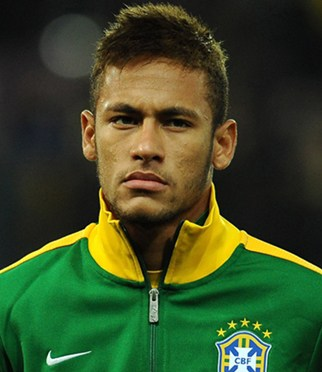

In [ ]:
img = cv2.imread('gdrive/My Drive/dataset_celebrity_class/' + fichiers[120])
cv2_imshow(img)

In [ ]:
# create labels
labels = ["CR7" for _ in range(26)]
labels += ["Messi" for _ in range(53-26)]
labels += ["Suarez" for _ in range(73-53)]
labels += ["Mo" for _ in range(99-73)]
labels += ["Neymar" for _ in range(129-99)]

# create images
images = []
for e in fichiers:  
  img = cv2.imread('gdrive/My Drive/dataset_celebrity_class/' + e)
  resized = cv2.resize(img, (240, 240), interpolation = cv2.INTER_AREA)
  images.append(resized)


In [ ]:
# labels0 = []
# images0 = []
# dirs = [dir for dir in listdir('gdrive/My Drive/photos')]
# for dir in dirs:
#   fichiers = [f for f in listdir('gdrive/My Drive/photos/'+dir) if "jpeg" in f or "png" in f]
#   images0 += [cv2.resize(cv2.imread('gdrive/My Drive/photos/'+dir+'/'+e), (240, 240), interpolation = cv2.INTER_AREA) for e in fichiers]
#   labels0 += [dir]*len(fichiers)

In [ ]:
# cv2_imshow(images[200])
# print(labels[200])

In [ ]:
images = np.array(images)
labels = np.array(labels)

## Data Augmentation

In [ ]:
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    rotated_image = cv2.warpAffine(image, M, (w, h))
    return rotated_image

def shift_image(image, shifts):
    (h, w) = image.shape[:2]
    shift_x, shift_y = shifts
    M = np.float32([[1,0,shift_x],[0,1,shift_y]])
    shifted_image = cv2.warpAffine(image, M, (h, w))
    return shifted_image
        
def brightness_image(image, rate):
    inc_brightness_images = np.clip(image*rate, 0.0, 1.0)
    return inc_brightness_images

def blur_image(image):
    blured_image = cv2.blur(image,(3,3))
    return blured_image

In [ ]:
#augmente data
augmented_images = []
augmented_y = []
for i in range(len(images)):
    image = images[i]
    rotated_image = rotate_image(image, 10)
    augmented_images.append(rotated_image)
    augmented_y.append(labels[i])

    rotated_image = rotate_image(image, -20)
    augmented_images.append(rotated_image)
    augmented_y.append(labels[i])

    shifted_image = shift_image(image,  [-10,-10])
    augmented_images.append(shifted_image)
    augmented_y.append(labels[i])

    shifted_image = shift_image(image,  [20, 10])
    augmented_images.append(shifted_image)
    augmented_y.append(labels[i])

    brighten_image = brightness_image(image, 0.6)
    augmented_images.append(brighten_image)
    augmented_y.append(labels[i])

    blured_image = blur_image(image)
    augmented_images.append(blured_image)
    augmented_y.append(labels[i])

augmented_images = np.array(augmented_images)
augmented_y = np.array(augmented_y)

images = np.concatenate((images, augmented_images), axis=0)
labels = np.concatenate((labels, augmented_y), axis=0)

In [ ]:
# shuffle data
X, y = shuffle(images, labels)
# split data between train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Number of classes
n_classes = len(set(labels))

In [ ]:
y_train = y_train.reshape((len(y_train),1))
enc = OneHotEncoder()
enc.fit(y_train)
y_train = enc.transform(y_train).toarray()

## HoG

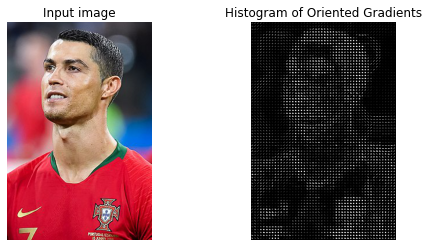

In [ ]:
image = plt.imread('gdrive/My Drive/dataset_celebrity_class/' + fichiers[0])

fd, hog_image = hog(image, orientations=9, pixels_per_cell=(5, 5), cells_per_block=(2, 2), visualize=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [ ]:
print("Number of inputs : ", image.shape[0]*image.shape[1]*image.shape[2])
print("Number of HoG descriptors", len(fd))

Number of inputs :  768180
Number of HoG descriptors 358668


## ORB

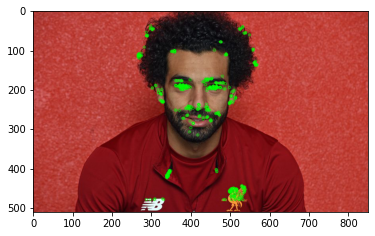

(<matplotlib.image.AxesImage at 0x7f80bfbdf890>, None)

In [ ]:
img = plt.imread('gdrive/My Drive/dataset_celebrity_class/' + fichiers[88])
# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints with ORB
kp = orb.detect(img,None)
# compute the descriptors with ORB
kp, des = orb.compute(img, kp)
# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

## BRIEF

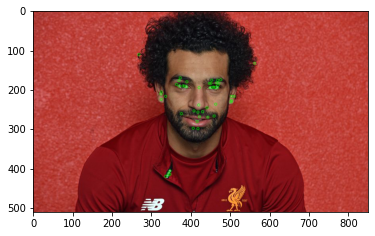

(<matplotlib.image.AxesImage at 0x7f80bf8e40d0>, None)

In [ ]:
img = plt.imread('gdrive/My Drive/dataset_celebrity_class/' + fichiers[88])

# Initiate FAST detector
star = cv2.xfeatures2d.StarDetector_create()

# Initiate BRIEF extractor
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

# find the keypoints with STAR
kp = star.detect(img,None)

# compute the descriptors with BRIEF
kp, des = brief.compute(img, kp)
img2 = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()


## FAST

Threshold: 10
nonmaxSuppression:True
neighborhood: 2
Total Keypoints with nonmaxSuppression: 4850


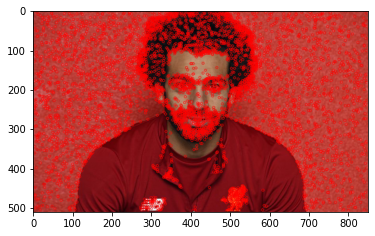

Total Keypoints without nonmaxSuppression: 17074


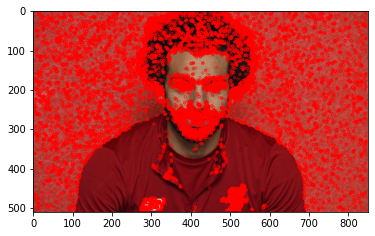

(<matplotlib.image.AxesImage at 0x7f80bf6da5d0>, None)

In [ ]:
img = plt.imread('gdrive/My Drive/dataset_celebrity_class/' + fichiers[88])
# Initiate FAST object with default values
fast = cv2.FastFeatureDetector_create()
# find and draw the keypoints
kp = fast.detect(img,None)
img2 = cv2.drawKeypoints(img, kp, None, color=(255,0,0))
# Print all default params
print( "Threshold: {}".format(fast.getThreshold()) )
print( "nonmaxSuppression:{}".format(fast.getNonmaxSuppression()) )
print( "neighborhood: {}".format(fast.getType()) )
print( "Total Keypoints with nonmaxSuppression: {}".format(len(kp)) )
cv2.imwrite('fast_true.png', img2)
plt.imshow(img2), plt.show()
# Disable nonmaxSuppression
fast.setNonmaxSuppression(0)
kp = fast.detect(img, None)
print( "Total Keypoints without nonmaxSuppression: {}".format(len(kp)) )
img3 = cv2.drawKeypoints(img, kp, None, color=(255,0,0))
cv2.imwrite('fast_false.png', img3)
plt.imshow(img3), plt.show()

## CNN with cross entropy loss

### Pre-trained model: InceptionV3

In [ ]:
base_model = InceptionV3(input_shape = (240, 240, 3), include_top = False, weights = 'imagenet')
base_model.trainable = False
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(n_classes, activation='softmax')(x)
model = tf.keras.models.Model(base_model.input, predictions)
#model.summary()

In [ ]:
model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])
inception_hist = model.fit(X_train, y_train, validation_split=0.2,steps_per_epoch = 12, epochs = 30)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/30
12/12 [==============================] - 28s 956ms/step - loss: 51.2330 - acc: 0.2964 - val_loss: 10.5789 - val_acc: 0.3931
Epoch 2/30
12/12 [==============================] - 4s 348ms/step - loss: 8.8118 - acc: 0.3951 - val_loss: 5.1817 - val_acc: 0.4345
Epoch 3/30
12/12 [==============================] - 4s 350ms/step - loss: 2.5488 - acc: 0.5165 - val_loss: 1.9839 - val_acc: 0.5931
Epoch 4/30
12/12 [==============================] - 4s 349ms/step - loss: 1.4287 - acc: 0.6395 - val_loss: 1.2768 - val_acc: 0.6414
Epoch 5/30
12/12 [==============================] - 4s 350ms/step - loss: 1.0791 - acc: 0.6638 - val_loss: 1.4582 - val_acc: 0.6552
Epoch 6/30
12/12 [==============================] - 4s 349ms/step - loss: 0.8805 - acc: 0.7244 - val_loss: 1.1471 - val_acc: 0.6759
Epoch 7/30
12/12 [==============================] - 4s 350ms/step - loss: 0.7014 - acc: 0.7539 - val_loss: 1.0998 - val_acc: 0.7241
Epoch 8/30
12/12 [==============================] - 4s 350ms/step - loss:

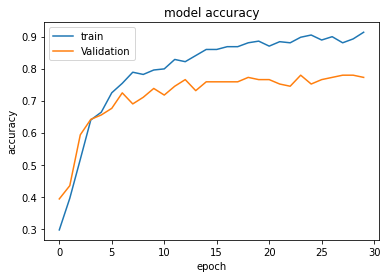

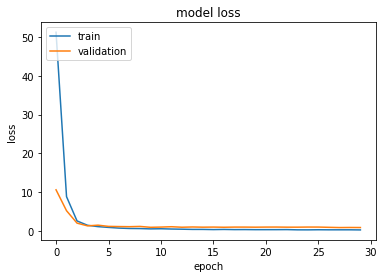

In [ ]:
# history for accuracy
plt.plot(inception_hist.history['acc'])
plt.plot(inception_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# history for loss
plt.plot(inception_hist.history['loss'])
plt.plot(inception_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Pre-trained model: VGG16

In [ ]:
base_model = VGG16(input_shape = (240, 240, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

# Flatten the output layer to 1 dimension
x = Conv2D(64, 3)(base_model.output)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.3)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(5, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

#model.summary()

In [ ]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'categorical_crossentropy',metrics = ['acc'])
vgg_hist = model.fit(X_train, y_train, validation_split=0.2,steps_per_epoch = 15, epochs = 30)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/30
15/15 [==============================] - 10s 616ms/step - loss: 12.2054 - acc: 0.4922 - val_loss: 0.8534 - val_acc: 0.7931
Epoch 2/30
15/15 [==============================] - 8s 571ms/step - loss: 0.8531 - acc: 0.8284 - val_loss: 0.8513 - val_acc: 0.8276
Epoch 3/30
15/15 [==============================] - 8s 570ms/step - loss: 0.5740 - acc: 0.8579 - val_loss: 0.5773 - val_acc: 0.8690
Epoch 4/30
15/15 [==============================] - 8s 571ms/step - loss: 0.4159 - acc: 0.8735 - val_loss: 1.2638 - val_acc: 0.8138
Epoch 5/30
15/15 [==============================] - 8s 572ms/step - loss: 0.3345 - acc: 0.8995 - val_loss: 0.5996 - val_acc: 0.8621
Epoch 6/30
15/15 [==============================] - 8s 573ms/step - loss: 0.3466 - acc: 0.8908 - val_loss: 0.5864 - val_acc: 0.8552
Epoch 7/30
15/15 [==============================] - 8s 573ms/step - loss: 0.3271 - acc: 0.8856 - val_loss: 0.6774 - val_acc: 0.8414
Epoch 8/30
15/15 [==============================] - 9s 576ms/step - loss: 

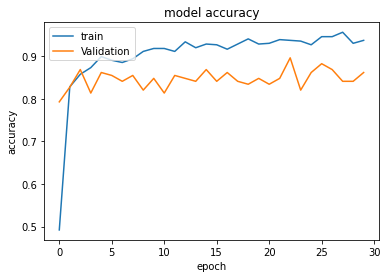

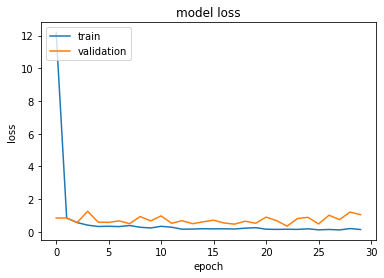

In [ ]:
# history for accuracy
plt.plot(vgg_hist.history['acc'])
plt.plot(vgg_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# history for loss
plt.plot(vgg_hist.history['loss'])
plt.plot(vgg_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Pre-trained model: ResNet50

#### Model

In [ ]:
base_model = ResNet50(input_shape=(240, 240,3), include_top=False, weights="imagenet")
for layer in base_model.layers:
    layer.trainable = False

base_model = Sequential()
base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))

# Flatten the output layer to 1 dimension
base_model.add(layers.Flatten())

base_model.add(layers.Dense(512, activation='relu'))
base_model.add(layers.Dropout(0.5))
base_model.add(layers.Dense(512, activation='relu'))
base_model.add(layers.Dropout(0.5))

# Add a fully connected layer with 512 hidden units and ReLU activation
base_model.add(layers.Dense(1024, activation='relu'))

# Add a dropout rate of 0.5
base_model.add(layers.Dropout(0.5)) 

# Add a final sigmoid layer with 1 node for classification output
base_model.add(Dense(5, activation='softmax'))

In [ ]:
base_model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])
res_hist = base_model.fit(X_train, y_train, validation_split=0.2,steps_per_epoch = 8, epochs = 20)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/20
8/8 [==============================] - 33s 2s/step - loss: 8.3442 - acc: 0.2357 - val_loss: 1.4744 - val_acc: 0.4276
Epoch 2/20
8/8 [==============================] - 18s 2s/step - loss: 5.0972 - acc: 0.2652 - val_loss: 1.3890 - val_acc: 0.4828
Epoch 3/20
8/8 [==============================] - 18s 2s/step - loss: 3.3346 - acc: 0.3726 - val_loss: 1.0520 - val_acc: 0.6069
Epoch 4/20
8/8 [==============================] - 18s 2s/step - loss: 2.6813 - acc: 0.4246 - val_loss: 0.9035 - val_acc: 0.6759
Epoch 5/20
8/8 [==============================] - 18s 2s/step - loss: 2.2281 - acc: 0.4783 - val_loss: 0.8140 - val_acc: 0.6759
Epoch 6/20
8/8 [==============================] - 18s 2s/step - loss: 1.7721 - acc: 0.5182 - val_loss: 0.6958 - val_acc: 0.7241
Epoch 7/20
8/8 [==============================] - 18s 2s/step - loss: 1.6202 - acc: 0.5442 - val_loss: 0.6299 - val_acc: 0.7379
Epoch 8/20
8/8 [==============================] - 18s 2s/step - loss: 1.1160 - acc: 0.6516 - val_loss: 0

In [ ]:
base_model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])
res_hist = base_model.fit(X_train, y_train, validation_split=0.2,steps_per_epoch = 8, epochs = 20)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
8/8 [==============================] - 18s 2s/step - loss: 0.1072 - acc: 0.9636 - val_loss: 0.2136 - val_acc: 0.9172
Epoch 2/20
8/8 [==============================] - 8s 1s/step - loss: 0.1178 - acc: 0.9619 - val_loss: 0.2421 - val_acc: 0.9034
Epoch 3/20
8/8 [==============================] - 8s 1s/step - loss: 0.1072 - acc: 0.9549 - val_loss: 0.2629 - val_acc: 0.9241
Epoch 4/20
8/8 [==============================] - 8s 1s/step - loss: 0.0947 - acc: 0.9671 - val_loss: 0.2402 - val_acc: 0.9172
Epoch 5/20
8/8 [==============================] - 8s 1s/step - loss: 0.1019 - acc: 0.9671 - val_loss: 0.3194 - val_acc: 0.9172
Epoch 6/20
8/8 [==============================] - 8s 1s/step - loss: 0.1037 - acc: 0.9688 - val_loss: 0.2507 - val_acc: 0.9034
Epoch 7/20
8/8 [==============================] - 8s 1s/step - loss: 0.1036 - acc: 0.9636 - val_loss: 0.2846 - val_acc: 0.9103
Epoch 8/20
8/8 [==============================] - 8s 1s/step - loss: 0.1089 - acc: 0.9601 - val_loss: 0.2613 -

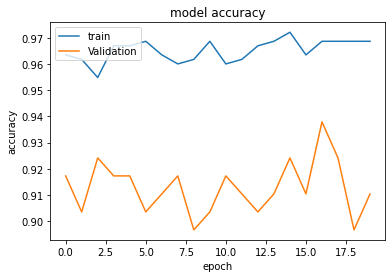

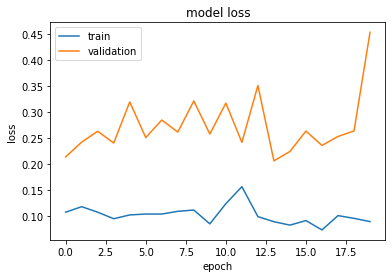

In [ ]:
# history for accuracy
plt.plot(res_hist.history['acc'])
plt.plot(res_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# history for loss
plt.plot(res_hist.history['loss'])
plt.plot(res_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### Predictions

In [ ]:
predictions = base_model.predict(X_test)
print(predictions)

[[1.49579957e-01 7.53555775e-01 9.53840688e-02 1.93421642e-04
  1.28670514e-03]
 [1.33732604e-02 5.93149126e-01 3.13637801e-03 3.46905697e-04
  3.89994413e-01]
 [2.25924941e-06 1.58500001e-01 1.48690349e-04 8.41311276e-01
  3.77423494e-05]
 [6.07111451e-06 4.38058019e-01 3.10806721e-01 2.55917985e-06
  2.51126647e-01]
 [2.36046247e-07 2.16823928e-02 3.58789111e-03 1.42984263e-07
  9.74729300e-01]
 [1.11350659e-02 5.30227609e-02 1.48691889e-02 2.96925694e-01
  6.24047279e-01]
 [7.75161936e-07 1.26708136e-03 9.95886147e-01 1.74909403e-07
  2.84587219e-03]
 [2.20381841e-03 1.25839037e-03 9.47429333e-04 1.06948847e-02
  9.84895468e-01]
 [2.62461195e-04 9.19198990e-02 4.19575013e-02 3.20471077e-06
  8.65856946e-01]
 [2.21917871e-02 9.52502191e-01 1.40843214e-02 8.66833143e-03
  2.55330629e-03]
 [9.74561810e-01 2.96685175e-06 2.38260964e-06 2.53114756e-02
  1.21260950e-04]
 [6.21098399e-01 2.84675248e-02 4.06371328e-05 4.47673556e-05
  3.50348771e-01]
 [9.18018050e-04 5.32852337e-02 8.715524

#### Model 2

In [ ]:
base_model = ResNet50(input_shape=(240, 240,3), include_top=False, weights="imagenet")
for layer in base_model.layers:
    layer.trainable = False

base_model = Sequential()
base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))

# Flatten the output layer to 1 dimension
base_model.add(layers.Flatten())

# Add a fully connected layer with 512 hidden units and ReLU activation
base_model.add(layers.Dense(1024, activation='relu'))

# Add a dropout rate of 0.5
base_model.add(layers.Dropout(0.5)) 

# Add a final sigmoid layer with 1 node for classification output
base_model.add(Dense(29, activation='softmax'))

In [ ]:
base_model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])
res_hist = base_model.fit(X_train, y_train, validation_split=0.2,steps_per_epoch = 8, epochs = 20)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


8/8 [==============================] - 22s 2s/step - loss: 20.4162 - acc: 0.0333 - val_loss: 9.9498 - val_acc: 0.0659
Epoch 2/20
8/8 [==============================] - 9s 1s/step - loss: 17.2804 - acc: 0.0528 - val_loss: 8.8955 - val_acc: 0.0549
Epoch 3/20
8/8 [==============================] - 9s 1s/step - loss: 15.5870 - acc: 0.1028 - val_loss: 8.3343 - val_acc: 0.0769
Epoch 4/20
8/8 [==============================] - 9s 1s/step - loss: 14.7712 - acc: 0.0528 - val_loss: 8.0458 - val_acc: 0.0879
Epoch 5/20
8/8 [==============================] - 9s 1s/step - loss: 13.3881 - acc: 0.0611 - val_loss: 7.7800 - val_acc: 0.0659
Epoch 6/20
8/8 [==============================] - 9s 1s/step - loss: 11.7025 - acc: 0.1028 - val_loss: 7.6083 - val_acc: 0.0879
Epoch 7/20
8/8 [==============================] - 9s 1s/step - loss: 11.7704 - acc: 0.0833 - val_loss: 7.4388 - val_acc: 0.0989
Epoch 8/20
8/8 [==============================] - 9s 1s/step - loss: 10.2852 - acc: 0.1361 - val_loss: 7.3946 - va

### Model from scratch

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5), activation='relu', input_shape=(240, 240, 3), padding='same'))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(5,5), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 240, 240, 32)      2432      
                                                                 
 conv2d_95 (Conv2D)          (None, 240, 240, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 119, 119, 32)     0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 119, 119, 32)      0         
                                                                 
 conv2d_96 (Conv2D)          (None, 119, 119, 64)      51264     
                                                                 
 conv2d_97 (Conv2D)          (None, 119, 119, 64)      36928     
                                                        

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])
history = model.fit(X_train, y_train, validation_split=0.2,steps_per_epoch = 12, epochs = 30)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/30
12/12 [==============================] - 7s 547ms/step - loss: 0.4403 - acc: 0.8076 - val_loss: 3.2091 - val_acc: 0.3655
Epoch 2/30
12/12 [==============================] - 6s 522ms/step - loss: 0.4735 - acc: 0.7851 - val_loss: 3.0434 - val_acc: 0.3655
Epoch 3/30
12/12 [==============================] - 6s 523ms/step - loss: 0.4638 - acc: 0.7903 - val_loss: 3.1626 - val_acc: 0.3724
Epoch 4/30
12/12 [==============================] - 6s 523ms/step - loss: 0.4559 - acc: 0.7920 - val_loss: 3.0114 - val_acc: 0.3655
Epoch 5/30
12/12 [==============================] - 6s 522ms/step - loss: 0.4432 - acc: 0.7972 - val_loss: 3.1014 - val_acc: 0.3655
Epoch 6/30
12/12 [==============================] - 6s 522ms/step - loss: 0.4500 - acc: 0.8059 - val_loss: 3.1764 - val_acc: 0.3724
Epoch 7/30
12/12 [==============================] - 6s 524ms/step - loss: 0.4350 - acc: 0.7972 - val_loss: 3.2541 - val_acc: 0.3655
Epoch 8/30
12/12 [==============================] - 6s 531ms/step - loss: 0.

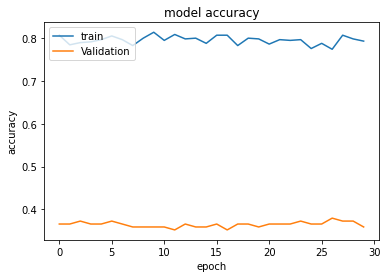

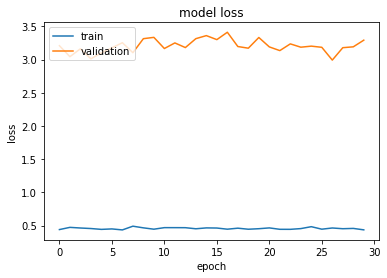

In [ ]:
# history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## SVM + HoG

In [ ]:
# from sklearn.datasets import fetch_lfw_people 
# lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [ ]:
hog_images = []
for img in images:
  hog_images.append(hog(img, orientations=7, pixels_per_cell=(4, 4),
                        cells_per_block=(2, 2), visualize=False, multichannel=True, feature_vector = True))
  
hog_images = np.array(hog_images)

In [ ]:
# shuffle data
X, y = shuffle(hog_images, labels)
# split data between train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)

(722, 79524)

In [ ]:
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
clf = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_pred, y_test))
 

0.5524861878453039


## VGGFace

In [ ]:
# to do